<a href="https://colab.research.google.com/github/jeromepatel/AIcrowd-challenges/blob/master/%5BExplainer%5D_Seismic_Facies_Identification_W%26B_with_Extra_Attributes%2C_Some_EDA_and_Catalyst_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seismic Facies Identification Challenge - Explainer Notebook with Added Perks

In this notebook, we are going to look at Seismic Facies Identification challenge which is a 3D semantic segmentation problem and with some tweaking, can be converted into 2D semantic segmentation task. 
This notebook aims to give an idea about previous work (notebooks at [this]() page) and summarizes a few very basic EDA, extra attibutes ideas and finally introduces a flexible and systemic approach for training models and tracking progress. 
* <b>What is 2D semantic segmentation?</b> </br>
 In simple words, semantic segmentation is a image recognition challenge with some perks where each pixel a class needs to be identified and tagged instead of whole image, so what we get in the end is a mask the size of original image segmented into different classes. As we all know, it requires a lot of data, different tools are used to prepared the dataset for segmentation maps from images.  
* what is w&B ?

* What is smp and why we are using it ?
* what is the need of preprocessing (in our case why augmentations and normalization)?

* Why we do exploratory data analysis ?


In [ ]:
#getting the dataset from the drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install segmentation_models_pytorch argus pytorch_toolbelt wandb catalyst --upgrade albumentations

     |████████████████████████████████| 576 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 34.7 MB/s 
     |████████████████████████████████| 120 kB 48.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#copy the dataset
!mkdir -p seismic-facies-identification-challenge
!rsync -avhW --compress-level=2 --info=progress2 /content/gdrive/MyDrive/Datasets/AIcrowd/seismic-facies-identification/data /content/seismic-facies-identification-challenge/data

sending incremental file list
created directory /content/seismic-facies-identification-challenge/data
data/
data/data_test_1.npz
        731.38M  13%   21.12MB/s    0:00:33 (xfr#1, to-chk=0/8)
data/data_test_2.npz
          1.78G  32%   21.06MB/s    0:01:20 (xfr#2, to-chk=5/8)
data/data_train.npz
          3.49G  63%   20.88MB/s    0:02:39 (xfr#3, to-chk=4/8)
data/data_train_processed.npz
          5.22G  95%   20.94MB/s    0:03:57 (xfr#4, to-chk=3/8)
data/labels_train.npz
          5.23G  95%   20.88MB/s    0:03:58 (xfr#5, to-chk=2/8)
data/sample_submission_1.npz
          5.33G  97%   20.68MB/s    0:04:05 (xfr#6, to-chk=1/8)
data/sample_submission_2.npz
          5.48G 100%   20.50MB/s    0:04:14 (xfr#7, to-chk=0/8)

sent 5.47G bytes  received 229 bytes  21.31M bytes/sec
total size is 5.48G  speedup is 1.00


In [ ]:
#importing libraries
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import segmentation_models_pytorch as smp
# import argus
# from argus.callbacks import MonitorCheckpoint, EarlyStopping, LoggingToFile, ReduceLROnPlateau
# import albumentations as A
# from pytorch_toolbelt.inference.tiles import ImageSlicer, CudaTileMerger
# from pytorch_toolbelt.losses import LovaszLoss

In [ ]:
%%time
train_data_full = np.load('/content/seismic-facies-identification-challenge/data/data/data_train.npz', allow_pickle=True, mmap_mode='r')['data']
train_label_full = np.load('/content/seismic-facies-identification-challenge/data/data/labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']

test_img = np.load('/content/seismic-facies-identification-challenge/data/data/data_test_2.npz', allow_pickle=True, mmap_mode='r')['data']


CPU times: user 23.6 s, sys: 4.04 s, total: 27.6 s
Wall time: 1min 9s


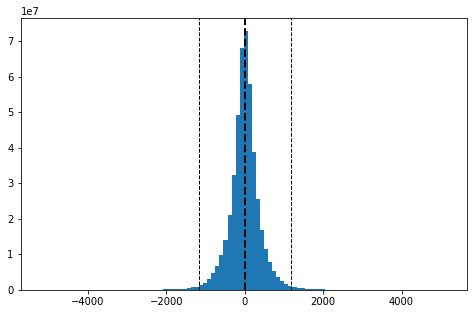

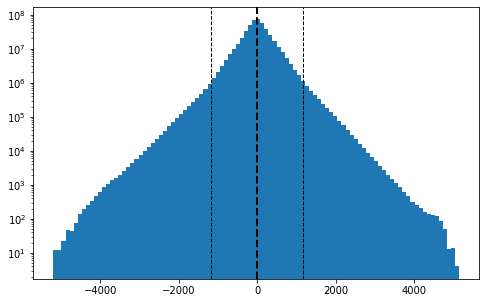

CPU times: user 29 s, sys: 1.55 s, total: 30.5 s
Wall time: 30.2 s


In [ ]:
%%time
mean, std = train_data_full.mean(), train_data_full.std()

plt.figure(figsize=(8, 5))
plt.hist(train_data_full.flatten(), bins=100)

plt.axvline(mean, color='k', linestyle='dashed', linewidth=2)
plt.axvline(mean + 3*std, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean - 3*std, color='k', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(train_data_full.flatten(), bins=100, log=True)

plt.axvline(mean, color='k', linestyle='dashed', linewidth=2)
plt.axvline(mean + 3*std, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean - 3*std, color='k', linestyle='dashed', linewidth=1)
plt.show()


1 ::: mean is -0.8623 ::: std is 213.2 ::: Basement/other
2 ::: mean is 0.9905 ::: std is 379.5 ::: Slope Mudstone A
3 ::: mean is -5.073 ::: std is 468.9 ::: Mass Transport Deposit
4 ::: mean is 2.11 ::: std is 453.0 ::: Slope Mudstone B
5 ::: mean is -18.73 ::: std is 655.1 ::: Slope Valley
6 ::: mean is 1.998 ::: std is 372.3 ::: Submarine Canyon System


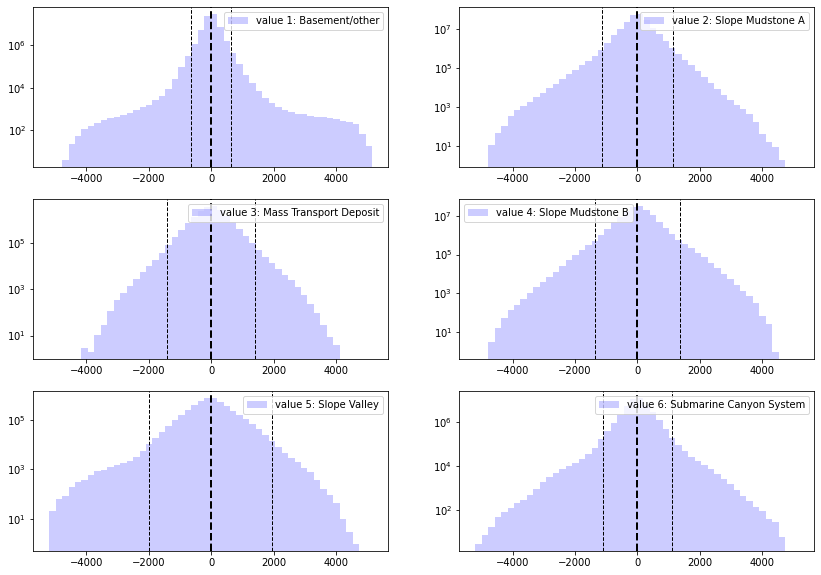

In [ ]:
ranges = train_data_full.min(), train_data_full.max()
values = np.unique(train_label_full)

data_histograms = [train_data_full[train_label_full == value].flatten()
                   for value in values]

CLASS_LABELS = [
    'Basement/other',
    'Slope Mudstone A',
    'Mass Transport\n Deposit',
    'Slope Mudstone B',
    'Slope Valley',
    'Submarine Canyon\n System'
]

fig, ax = plt.subplots(3, 2, figsize=(14, 10))

for i, value in enumerate(values):
    data = data_histograms[i]
    mean_, std_ = data.mean(), data.std()
    ax_ = ax[i // 2, i % 2]
    
    label_name = CLASS_LABELS[value-1].replace('\n', '')
    
    ax_.hist(data, log=True, bins=50, range=ranges, color='b',
                     label=f'value {value}: {label_name}', alpha=0.2)
    ax_.axvline(mean_, color='k', linestyle='dashed', linewidth=2)
    ax_.axvline(mean_ + 3*std_, color='k', linestyle='dashed', linewidth=1)
    ax_.axvline(mean_ - 3*std_, color='k', linestyle='dashed', linewidth=1)
    
    ax_.legend(loc='best')
    
    print(f'{value} ::: mean is {mean_:4.4} ::: std is {std_:4.4} ::: {label_name}')

fig.show()

In [ ]:
#add more EDA graphs for indepth info
#also conclude some points from graphs, add extra attributes generation function
#conclude how to use them 
#finally write catalyst benefits, easy experimentation with wandb and if someone is using leocd notebook give then code for wandb even without using 
#catlyst

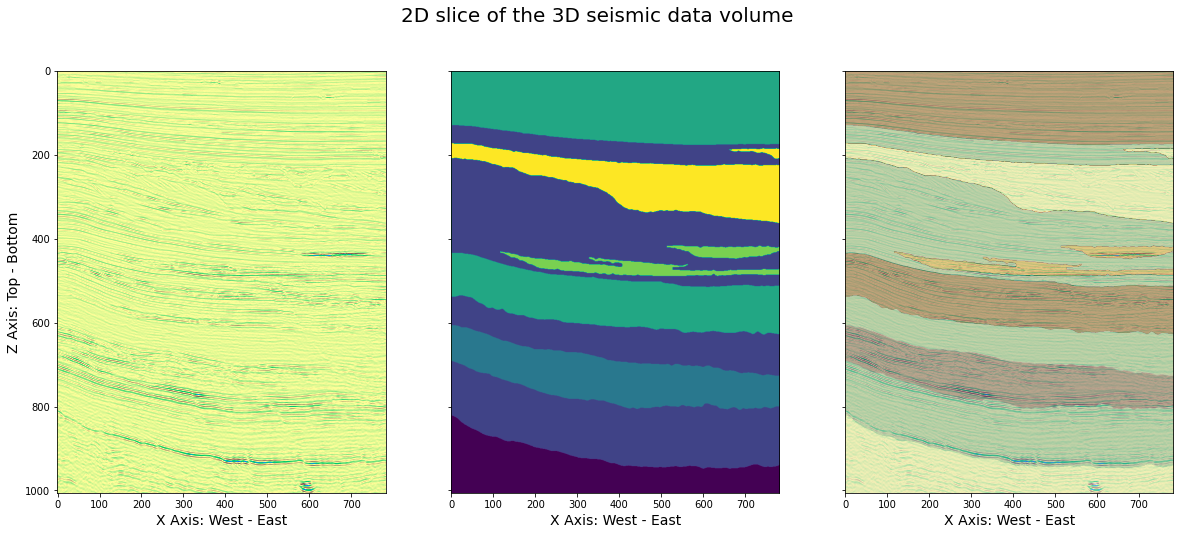

In [ ]:
#let's look at 2d section of 3d data using below slice visualization 
fig, ax = plt.subplots(1,3, sharey=True);
fig.set_size_inches(20, 8);
fig.suptitle("2D slice of the 3D seismic data volume", fontsize=20);

ax[0].imshow(train_data_full[:, :, 100], cmap='terrain');
ax[0].set_ylabel('Z Axis: Top - Bottom', fontsize=14);
ax[1].imshow(train_label_full[:, :, 100]);
ax[2].imshow(train_data_full[:, :, 100], cmap='terrain');
ax[2].imshow(train_label_full[:, :, 100], alpha=0.4, cmap='twilight');

for i in range(3):
    ax[i].set_xlabel('X Axis: West - East', fontsize=14);


## EDA - Extra attributes

In [ ]:
!pip install argus pytorch_toolbelt

In [ ]:
!pip install wandb

In [ ]:
! pip install --upgrade albumentations

In [ ]:
!pip install catalyst

# Using Catalyst with wandb API, the final model training

In [1]:
import os
from tempfile import TemporaryDirectory

from pytest import mark
from torch import nn, optim
from torch.utils.data import DataLoader

import catalyst
from catalyst import dl, utils, metrics
from catalyst.contrib.datasets import MNIST
from catalyst.data.transforms import ToTensor
from catalyst.settings import IS_CUDA_AVAILABLE, NUM_CUDA_DEVICES, SETTINGS

In [2]:
import albumentations as A

from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import gc
import tqdm
from sklearn.model_selection import StratifiedKFold
import cv2

import torch
torch.backends.cudnn.benchmark = True
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

import segmentation_models_pytorch as smp

In [3]:
competition_path = "/content/seismic-facies-identification-challenge/"
data_path = competition_path + "data/data/"
train_img = np.load(data_path+'data_train.npz', allow_pickle=True, mmap_mode='r')['data']
train_labels = np.load(data_path+'labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']
test1_img = np.load(data_path+'data_test_1.npz', allow_pickle=True, mmap_mode='r')['data']
test2_img = np.load(data_path+'data_test_2.npz', allow_pickle=True, mmap_mode='r')['data']
train_labels -= 1
train_labels[:,0,:] = train_labels[:,1,:]

In [4]:
print(f"train_img {train_img.shape} train_lables {train_labels.shape} test1_img {test1_img.shape} test2_img {test2_img.shape}")

"""
# normalize values to [0, 1]
_min = min(train_img.min(), test1_img.min(), test2_img.min())
_max = max(train_img.max(), test1_img.max(), test2_img.max())
train_img = (train_img - _min) / (_max - _min)
test1_img = (test1_img - _min) / (_max - _min)
test2_img = (test2_img - _min) / (_max - _min)
"""
# normalize values to max(abs())==1
_min = min(train_img.min(), test1_img.min(), test2_img.min())
_max = max(train_img.max(), test1_img.max(), test2_img.max())
divide = max(-_min, _max)
train_img = train_img / divide
test1_img = test1_img / divide
test2_img = test2_img / divide

train_img (1006, 782, 590) train_lables (1006, 782, 590) test1_img (1006, 782, 251) test2_img (1006, 334, 841)


In [5]:
def calculate_weights(train_labels):
  labels = [0, 1, 2, 3, 4, 5]
  weights = []
  for label in labels:
    weights.append(train_labels.size / np.sum(train_labels==label) / len(labels))
  return weights
def train_transform(image, mask):
  binary_class = "class_012345"
  if binary_class == "class_012345" or binary_class == "class_0123":
    height = 896
    width = 256
  elif binary_class == "class_4":
    height = 448
    width = 448
  elif binary_class == "class_5":
    height = 544
    width = 256
  return A.Compose([   
    A.ShiftScaleRotate(p=0.7, shift_limit=0, scale_limit=0.15, rotate_limit=25),
    #A.Rotate(p=0.8, limit=25, interpolation=cv2.INTER_LINEAR), # cv2.INTER_LINEAR or cv2.INTER_NEAREST
    #A.OneOf([
    #     A.ShiftScaleRotate(p=0.8, shift_limit=0, scale_limit=0.15, rotate_limit=25),
    #     A.IAAPiecewiseAffine(p=0.8, scale=(0.03, 0.12), nb_rows=4, nb_cols=4),
    #], p=1),
    A.RandomCrop(p=1, height=height, width=width),
    A.MultiplicativeNoise(p=0.7, multiplier=(0.8, 1.2), per_channel=False, elementwise=False),
    #A.GaussNoise(p=0.8, var_limit=(10.0, 50.0)), # var_limit to be optimized
    A.HorizontalFlip(p=0.5),
  ])(image=image, mask=mask)

def valid_transform(image, mask):
  binary_class = "class_012345"
  if binary_class == "class_012345" or binary_class == "class_0123":
    height = 1024
    width = 800
  elif binary_class == "class_4":
    height = 448
    width = 448
  elif binary_class == "class_5":
    height = 544
    width = 800
  return A.Compose([
    A.PadIfNeeded(p=1, min_height=height, min_width=width), # border_mode=4 reflect_101 
  ])(image=image, mask=mask)

In [6]:
#we create dataset pytorch class for image handling and data loading during training
class SeismicFaciesDataset(Dataset):
  def __init__(self, img, labels, train=True, both_axis=True, channels=3):
    self.img = img
    self.labels = labels
    self.train = train
    self.both_axis = both_axis
    self.channels = channels
    self.side_channels = int((channels - 1) / 2)
    self.xaxis = self.img.shape[1]
    self.yaxis = self.img.shape[2]
    self.ximages = self.xaxis - self.side_channels * 2
    self.yimages = self.yaxis - self.side_channels * 2

  def __len__(self):
    if self.both_axis:
      return self.ximages + self.yimages
    else:
      return self.yimages

  def __getitem__(self, idx):
    if idx < self.yimages:
      image, mask = self.img[:, :, idx:idx+self.channels], self.labels[:, :, idx+self.side_channels]
    else:
      idx = idx - self.yimages
      image, mask = self.img[:, idx:idx+self.channels], self.labels[:, idx+self.side_channels]
      image = np.moveaxis(image, 1, 2)

    if self.train:
      augmented = train_transform(image, mask)
    else:
      augmented = valid_transform(image, mask)
    image, mask = augmented['image'], augmented['mask']
        
    return [np.moveaxis(image, 2, 0), np.expand_dims(mask, 0)]

#separate dataset class for test images
class SeismicFaciesTestset(Dataset):
  def __init__(self, img, batch_axis=2, channels=3): # batch_axis = 1 (x_axis) or 2 (y_axis)
    self.img = img
    self.batch_axis = batch_axis
    self.channels = channels
    self.side_channels = int((channels - 1) / 2)
    self.image_nb = self.img.shape[self.batch_axis]

  def __len__(self):
    return self.image_nb

  def __getitem__(self, idx):
    if idx < self.side_channels:
      idx = self.side_channels
    
    if idx > self.image_nb-self.side_channels-1:
      idx = self.image_nb-self.side_channels-1
    if self.batch_axis == 2:
      image = self.img[:, :, idx-self.side_channels:idx+self.side_channels+1]
    else:
      image = self.img[:, idx-self.side_channels:idx+self.side_channels+1, :]
      image = np.moveaxis(image, 1, 2)

    #image = A.PadIfNeeded(p=1, min_height=1024, min_width=800)(image=image)["image"]
    bboxes = [[0, 0, image.shape[1], image.shape[0], "original_image"]] # width and then height
    augmented = A.Compose([
          A.PadIfNeeded(p=1, min_height=1024, min_width=1024),
          ], bbox_params=A.BboxParams(format='coco'))(image=image, bboxes=bboxes)
    image, self.bboxes = augmented["image"], augmented["bboxes"]
    return [np.moveaxis(image, 2, 0)]

In [16]:
#this class represents catalyst Runner Class which we will be using to perform  all the required training steps, we just need to change this class whenever required. 
class CustomRunner(dl.IRunner):
    def __init__(self, logdir, device):
        super().__init__()
        self._logdir = logdir
        self._device = device
        self._name = "seismic-facies-identification"
        self.classes = 6
        self.channels = 1
        self._weights = [1, 1, 1, 1, 20, 20]

    def get_engine(self):
        return dl.DeviceEngine(self._device)

    def get_loggers(self):
        return {"wandb": dl.WandbLogger(project="seismic_catalyst_wandb", name=self._name)}
    
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveValueMetric(compute_on_call=False)
            for key in ["loss", "accuracy_01",  "f1_score"]
        }

    @property
    def stages(self):
        return ["train_freezed", "train_unfreezed"]

    def get_stage_len(self, stage: str) -> int:
        return 10

    def get_loaders(self, stage: str):
        # train
        valid_ratio = 0.1
        dataset = SeismicFaciesDataset(train_img, train_labels, channels=self.channels)
        nb_valid_xaxis = int(dataset.xaxis * valid_ratio)
        nb_valid_yaxis = int(dataset.yaxis * valid_ratio)
        # split (train set = whole data; valid set = near to test set)
        train_index = list(range(0, dataset.__len__()))
        valid_index = list(range(dataset.__len__() - nb_valid_xaxis, dataset.__len__()))

        train_dataset, valid_dataset = Subset(dataset, train_index), Subset(copy(dataset), valid_index)
        loaders = {
         "train": DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True, drop_last=True),
         "valid": DataLoader(valid_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=False),
        }
        return loaders

    def get_model(self, stage: str):
        model = smp.DeepLabV3Plus(encoder_name="efficientnet-b0", in_channels=self.channels, classes=self.classes, activation="softmax", encoder_weights='imagenet')
        return model

    def get_criterion(self, stage: str):
        return nn.CrossEntropyLoss(weight=torch.FloatTensor(self._weights).cuda())

    def get_optimizer(self, stage: str, model):
        if stage == "train_unfreezed":
            return optim.Adam(model.parameters(), lr=1e-3)
        else:
            return optim.SGD(model.parameters(), lr=1e-1)

    def get_scheduler(self, stage: str, optimizer):
        return None

    def get_callbacks(self, stage: str):
        callbacks = {
            "checkpoint": dl.CheckpointCallback(
                self._logdir, loader_key="valid", metric_key="loss", minimize=True, save_n_best=3
            ),
            # "criterion": dl.CriterionCallback(
            #     metric_key="loss", input_key="logits", target_key="targets"
            # ),
            # "optimizer": dl.OptimizerCallback(
            #     metric_key="loss",
            #     grad_clip_fn=nn.utils.clip_grad_norm_,
            #     grad_clip_params={"max_norm": 1.0},
            # ),
        #     "accuracy": dl.AccuracyCallback(
        #     input_key="logits", target_key="targets", num_classes=self.classes
        # ),
        }
        return callbacks

    def handle_batch(self, batch):
        # model train/valid step
        x, y = batch
        y_hat = self.model(x)
        
        # loss = self.criterion["CE"](y_hat, torch.squeeze(y.long()))*0.3 + self.criterion["GDice"](y_hat, torch.squeeze(y.long()))*0.7

        loss = self.criterion(y_hat, torch.squeeze(y.long()))
        y_hat_reshaped = y_hat.permute(0, 2, 3, 1).reshape(-1, self.classes)
        y_reshaped = y.permute(0, 2, 3, 1).reshape(-1, 1)

        # f1_score = sklearn.metrics.f1_score(y_reshaped.cpu().detach().numpy(), y_hat_reshaped.cpu().detach().numpy().argmax(axis=1), average='macro')
        accuracy01, accuracy03 = catalyst.metrics.accuracy(y_hat_reshaped, y_reshaped, topk=(1, 3))

        # [accuracy01] = catalyst.metrics.accuracy(y_hat_reshaped, y_reshaped)
        f1_score = catalyst.metrics.f1_score(torch.argmax(y_hat_reshaped, dim=1, keepdims=True), y_reshaped, num_classes=self.classes)

        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat,
        }

        self.batch_metrics.update(
            {"loss": loss, "accuracy_01": accuracy01, "f1_score": torch.mean(f1_score)} # "accuracy_2": accuracy02, "f1_score": f1_score
        )

        for key in ["loss", "accuracy_01", "f1_score"]:
            self.meters[key].update(self.batch_metrics[key].item(),
                                    self.batch_size)
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def on_loader_end(self, runner):
        for key in ["loss", "accuracy_01", "f1_score"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)
        

In [17]:
#running the actual code
runner = CustomRunner("./logs", "cuda:0")
runner.run()

/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:624: UserWarning: No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?
  "No ``ICriterionCallback/CriterionCallback`` were found "
/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:630: UserWarning: No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run backward pass during ``runner.handle_batch``?
  "No ``IOptimizerCallback/OptimizerCallback`` were found "
/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Top best models:
logs/train_freezed.1.pth	1.7747
Top best models:
logs/train_unfreezed.1.pth	1.7941


accuracy_01_batch/train,▂▃▂▂▁▂▂▁▃▁▁▂▁▁▂▄▄▂▃▁▆▇▇▇▇▆█▆▇▇▇█▇▆▇█▇▇▇▆
accuracy_01_batch/valid,▂▃▁▂▁▁▁▂▂▂▁▁▂▂▂▃▁▂▂▃▆▇▆█▅▇▅▆▆▆▆▇▅▆▆▇▆▆▅▇
accuracy_01_epoch/train,▁█
accuracy_01_epoch/valid,▁█
f1_score_batch/train,▁▂▂▃▂▂▂▂▂▁▂▃▂▁▂▄▃▃▃▂▅▇▇▆▇▆▇▆▆█▆██▆▇▇▆▇▇▆
f1_score_batch/valid,▄▄▃▃▂▂▃▃▂▂▂▂▃▄▃▅▁▄▄▅▅▆▆▇▅█▅▆▅▆█▇▅▇▆▆▆█▅▅
f1_score_epoch/train,▁█
f1_score_epoch/valid,▁█
loss_batch/train,▅▃▃▅█▄▆▆▆▄▃▄▆▄▅▂▃▅▅██▄▃▆▄▄▄▆▄▃▄▁▁▄▄▄▆▄▃▅
loss_batch/valid,▃▂▅▅▄▁▃▃▃▂▄▅▃▅▃▂▁▃▃▆█▆▇▇▆▆▆▆▅▅▅▃▆▆▅▇▅▇▆▅
loss_epoch/train,▁█


#Alternate Solution Leo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import albumentations as A
import os
from ipywidgets import IntProgress
from IPython.display import display
import time
import cv2
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score  #for score metric calculation
def _prf_divide(numerator, denominator, ):
    """Performs division and handles divide-by-zero.
    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). 
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    return result

def compute_scores(y_true, y_pred, class_weights=[1, 1, 1, 1, 20, 20]):
    """
    Computes the weighted & unweighted f1_score and accuracy
    Using the standard F1-Score and class-wise accuracy computations were quite 
    slow as we were doing a lot of redundant work across all score computations,
    hence we have implemented this from the base principles.
    Please refer to the inline comments.
    """

    # Initial Housekeeping Taks1
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    class_weights = np.array(class_weights)
    # print(np.max(y_true))
    # print(np.max(y_pred))
    # print(np.min(y_true))
    # print(np.min(y_pred))
    # Computing Multilabel Confusion Matrix
    #print("--------- Computing MCM... ")
    #begin_time = time.time()
    MCM = multilabel_confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5,6])
    #print("MCM computation time  : ", time.time() - begin_time)
    
    """
    Gather True Positives, True Negatives, False Positives, False Negatives
    """
    tp_sum = MCM[:, 1, 1]
    tn_sum = MCM[:, 0, 0]
    fn_sum = MCM[:, 1, 0]
    fp_sum = MCM[:, 0, 1]
    
    #print("--------- Computing per class instances... ")
    per_class_instances = np.bincount(y_true) # Helps keep a track of total number of instances per class
    per_class_instances = per_class_instances[1:] # as the class names in the dataset are NOT zero-indexed
    
    assert class_weights.shape == per_class_instances.shape
    
    #print("--------- Computing precision... ")
    # precision : tp / (tp + fp)
    precision = _prf_divide(
                    tp_sum,
                    (tp_sum + fp_sum)
                )
    #print("--------- Computing recall... ")                        
    # recall : tp / (tp + fn)
    recall = _prf_divide(
                    tp_sum,
                    (tp_sum + fn_sum)
                )

    #print("--------- Computing F1 score... ")
    # f1 : 2 * (recall * precision) / (recall + precision)
    f1_score = _prf_divide(
                    2 * precision * recall,
                    precision + recall
                )
    #print("--------- Computing Accuracy... ")
    # accuracy = tp_sum / instances_per_class
    # NOTE: we are computing the accuracy independently for all the class specific subgroups
    # accuracy = _prf_divide(
    #                 tp_sum,
    #                 per_class_instances
    #             )
    # print(class_weights)
    # print(f1_score)
    f1_score_weighted = np.dot(class_weights, f1_score) / np.sum(class_weights)
    f1_score_unweighted = f1_score.mean()

    # accuracy_weighted = np.dot(class_weights, accuracy) / np.sum(class_weights)
    # accuracy_unweighted = accuracy.mean()

    return f1_score_weighted, f1_score_unweighted#, accuracy_weighted, f1_score_unweighted, accuracy_unweighted



In [ ]:
batch_size = 10      
num_epochs = 40      
num_classes = 6       
learning_rate = 0.00085 

model = smp.PSPNet(
    encoder_name="efficientnet-b3",        
    encoder_weights=None,     
    in_channels=1,                  
    classes=num_classes,                    
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("")

In [ ]:
class seisdataset_train(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set
        self.n_sample = self.x.shape[1]+self.x.shape[2]+self.x.shape[1]
        self.aug = A.Compose([
            A.Resize(p=1, height=640, width=320, interpolation=1)
        ]) 
        self.aug2 = A.Compose([
            #A.RandomSizedCrop(p=1.0, min_max_height=(1006, 1006), height=1006, width=256, w2h_ratio=1.0, interpolation=0),
            #A.GridDistortion(p=0.3, num_steps=6, distort_limit=(-0.2, -0.05), border_mode=1),
            A.ElasticTransform(p=0.2,alpha=100, sigma=8, alpha_affine=0, border_mode=1),
            A.ShiftScaleRotate(p=0.5, shift_limit=(0.0, 0.0), scale_limit=(0.01, 0.25), rotate_limit=(-15, 15), interpolation=0, border_mode=1),
            A.RandomCrop(900, 250, p=0.3),
            A.Resize(p=1, height=640, width=320, interpolation=0)
            
        ])  

    def __len__(self):
        return self.n_sample
    
    def __getitem__(self, index):
        if index < self.x.shape[1]:
          idx = index
          batch_x = self.x[:,idx,:]
          batch_y = self.y[:,idx,:]-1
          augmented = self.aug(image=batch_x, mask=batch_y)
        elif self.x.shape[1] <= index < (self.x.shape[1]+self.x.shape[2]):
          idx = index-self.x.shape[1]
          batch_x = self.x[:,:,idx]
          batch_y = self.y[:,:,idx]-1
          augmented = self.aug2(image=batch_x, mask=batch_y)
        elif index >= self.x.shape[1]+self.x.shape[2]:
          idx = index-self.x.shape[1]-self.x.shape[2]
          batch_x = self.x[:,idx,:]
          batch_y = self.y[:,idx,:]-1
          augmented = self.aug2(image=batch_x, mask=batch_y)          
        image, mask = augmented['image'], augmented['mask']
        return image[None,:,:], mask
    
class seisdataset_test(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set
        self.n_sample = self.x.shape[1]
        self.aug2 = A.Compose([
            A.Resize(p=1, height=640, width=320, interpolation=0)
        ])  

    def __len__(self):
        return self.n_sample
    
    def __getitem__(self, index):
        batch_x = self.x[:,index,:]
        batch_y = self.y[:,index,:]-1
        augmented = self.aug2(image=batch_x, mask=batch_y)
        image, mask = augmented['image'], augmented['mask']
        return image[None,:,:], mask

In [ ]:
split_sample = 0.9
test_data = train_data_full[:,:train_data_full.shape[1]-int(train_data_full.shape[1]*split_sample),:]
train_data = train_data_full[:,train_data_full.shape[1]-int(train_data_full.shape[1]*split_sample):,:]
test_label = train_label_full[:,:train_label_full.shape[1]-int(train_label_full.shape[1]*split_sample),:]
train_label = train_label_full[:,train_label_full.shape[1]-int(train_label_full.shape[1]*split_sample):,:]

train_dataset = seisdataset_train(train_data, train_label)
def get_data_loaders(batch_size):
    train_dataset = seisdataset_train(train_data, train_label)
    test_dataset = seisdataset_test(test_data, test_label)
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

train_loader,test_loader=get_data_loaders(batch_size)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
test_F1_uw = []
train_acc = []
test_acc = []
F1_old = 0.0
F1uw_old = 0.0

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#use this code in case your challenge code/process is different than mine and you don't want to use catalyst. This code is modified code of starter notebook from 
@leo
#init weights and baises
import wandb
from tqdm import tqdm

wandb.init(project='seismic-facies-AIcrowd-pytorch',
           config = {'batch_size': batch_size,      
                        'num_epochs' :num_epochs ,     
                        'num_classes': num_classes,       
                        'learning_rate': learning_rate })

for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    F1uw_test = 0.0
    acc_test = 0.0    
    model.train()
    for i, (data, label) in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten()+1, pred.flatten()+1)
        f1s, f1uw = compute_scores(label.cpu().numpy().flatten()+1, pred.flatten()+1)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc

        if i % 20 == 19:    # print every 20 batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, train_loss))
            wandb.log({'epoch': epoch+1, 'train_loss': train_loss})
            running_loss = 0.0
        
    model.eval()
    for data, label in test_loader:        
        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten()+1, pred.flatten()+1)
        f1s, f1uw = compute_scores(label.cpu().numpy().flatten()+1, pred.flatten()+1)  
        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        F1uw_test += f1uw
        acc_test += acc

    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size    
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    F1uw_test = F1uw_test /len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    test_F1_uw.append(F1uw_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)      

    if F1_old < F1_test:
      F1_old = F1_test
      torch.save(model.state_dict(), 'modelbestf1_weighted_run1.ckpt')
    if F1uw_old < F1uw_test:
      F1uw_old = F1uw_test
      torch.save(model.state_dict(), 'modelbestf1_unweighted_run1.ckpt')  

    # print
    print('Epoch: {} \tTrain Loss: {:.3f} \tVal. Loss: {:.3f} \tF1_train: {:.3f} \tF1_test: {:.3f} \tF1u_test: {:.3f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test, F1uw_test))

wandb: Currently logged in as: jeromepatel (use `wandb login --relogin` to force relogin)


 10%|█         | 20/199 [00:44<05:52,  1.97s/it]

[2,    20] loss: 243.912


 20%|██        | 40/199 [01:21<04:31,  1.71s/it]

[2,    40] loss: 389.990


 30%|███       | 60/199 [01:59<05:39,  2.44s/it]

[2,    60] loss: 499.619


 40%|████      | 80/199 [02:36<03:54,  1.97s/it]

[2,    80] loss: 587.648


 50%|█████     | 100/199 [03:13<03:01,  1.83s/it]

[2,   100] loss: 657.560


 60%|██████    | 120/199 [03:49<02:34,  1.96s/it]

[2,   120] loss: 719.826


 70%|███████   | 140/199 [04:25<02:31,  2.57s/it]

[2,   140] loss: 781.404


 80%|████████  | 160/199 [05:00<01:26,  2.22s/it]

[2,   160] loss: 835.353


 90%|█████████ | 180/199 [05:34<00:32,  1.73s/it]

[2,   180] loss: 881.772


100%|██████████| 199/199 [06:08<00:00,  1.85s/it]


Epoch: 1 	Train Loss: 0.464 	Val. Loss: 26.848 	F1_train: 0.556 	F1_test: 0.008 	F1u_test: 0.056


 10%|█         | 20/199 [00:37<06:04,  2.04s/it]

[3,    20] loss: 47.640


 20%|██        | 40/199 [01:13<05:55,  2.23s/it]

[3,    40] loss: 91.418


 30%|███       | 60/199 [01:48<04:08,  1.79s/it]

[3,    60] loss: 135.410


 40%|████      | 80/199 [02:25<05:05,  2.57s/it]

[3,    80] loss: 177.288


 50%|█████     | 100/199 [03:02<03:14,  1.97s/it]

[3,   100] loss: 216.719


 60%|██████    | 120/199 [03:36<02:14,  1.70s/it]

[3,   120] loss: 254.484


 70%|███████   | 140/199 [04:13<01:29,  1.52s/it]

[3,   140] loss: 291.275


 80%|████████  | 160/199 [04:50<01:00,  1.56s/it]

[3,   160] loss: 326.792


 90%|█████████ | 180/199 [05:26<00:28,  1.50s/it]

[3,   180] loss: 359.987


100%|██████████| 199/199 [06:00<00:00,  1.81s/it]


Epoch: 2 	Train Loss: 0.195 	Val. Loss: 23.247 	F1_train: 0.754 	F1_test: 0.065 	F1u_test: 0.196


 10%|█         | 20/199 [00:38<05:16,  1.77s/it]

[4,    20] loss: 31.487


 20%|██        | 40/199 [01:16<05:52,  2.22s/it]

[4,    40] loss: 62.230


 30%|███       | 60/199 [01:52<03:21,  1.45s/it]

[4,    60] loss: 92.989


 40%|████      | 80/199 [02:27<03:00,  1.51s/it]

[4,    80] loss: 122.739


 50%|█████     | 100/199 [03:05<04:03,  2.46s/it]

[4,   100] loss: 153.205


 60%|██████    | 120/199 [03:41<02:17,  1.74s/it]

[4,   120] loss: 182.705


 70%|███████   | 140/199 [04:19<01:54,  1.94s/it]

[4,   140] loss: 211.271


 80%|████████  | 160/199 [04:57<00:58,  1.50s/it]

[4,   160] loss: 239.011


 90%|█████████ | 180/199 [05:32<00:32,  1.73s/it]

[4,   180] loss: 268.384


100%|██████████| 199/199 [06:06<00:00,  1.84s/it]


Epoch: 3 	Train Loss: 0.148 	Val. Loss: 1.895 	F1_train: 0.807 	F1_test: 0.349 	F1u_test: 0.641


 10%|█         | 20/199 [00:35<05:03,  1.69s/it]

[5,    20] loss: 27.147


 20%|██        | 40/199 [01:10<04:32,  1.71s/it]

[5,    40] loss: 51.793


 30%|███       | 60/199 [01:47<03:56,  1.70s/it]

[5,    60] loss: 77.580


 40%|████      | 80/199 [02:23<03:57,  2.00s/it]

[5,    80] loss: 102.186


 50%|█████     | 100/199 [03:00<03:01,  1.83s/it]

[5,   100] loss: 128.734


 60%|██████    | 120/199 [03:35<02:30,  1.91s/it]

[5,   120] loss: 153.494


 70%|███████   | 140/199 [04:09<01:26,  1.47s/it]

[5,   140] loss: 176.466


 80%|████████  | 160/199 [04:46<01:08,  1.74s/it]

[5,   160] loss: 200.028


 90%|█████████ | 180/199 [05:23<00:29,  1.56s/it]

[5,   180] loss: 225.647


100%|██████████| 199/199 [06:00<00:00,  1.81s/it]


Epoch: 4 	Train Loss: 0.125 	Val. Loss: 1.467 	F1_train: 0.831 	F1_test: 0.397 	F1u_test: 0.662


 10%|█         | 20/199 [00:36<05:19,  1.78s/it]

[6,    20] loss: 23.034


 20%|██        | 40/199 [01:13<04:48,  1.81s/it]

[6,    40] loss: 48.018


 30%|███       | 60/199 [01:47<03:53,  1.68s/it]

[6,    60] loss: 69.359


 40%|████      | 80/199 [02:24<03:23,  1.71s/it]

[6,    80] loss: 92.217


 50%|█████     | 100/199 [03:00<03:30,  2.12s/it]

[6,   100] loss: 115.101


 60%|██████    | 120/199 [03:36<02:36,  1.98s/it]

[6,   120] loss: 138.529


 70%|███████   | 140/199 [04:12<02:01,  2.06s/it]

[6,   140] loss: 161.984


 80%|████████  | 160/199 [04:50<01:54,  2.93s/it]

[6,   160] loss: 182.775


 90%|█████████ | 180/199 [05:28<00:28,  1.50s/it]

[6,   180] loss: 203.637


100%|██████████| 199/199 [06:02<00:00,  1.82s/it]


Epoch: 5 	Train Loss: 0.112 	Val. Loss: 1.292 	F1_train: 0.848 	F1_test: 0.398 	F1u_test: 0.674


 10%|█         | 20/199 [00:40<05:24,  1.81s/it]

[7,    20] loss: 20.119


 20%|██        | 40/199 [01:15<04:39,  1.76s/it]

[7,    40] loss: 40.630


 30%|███       | 60/199 [01:50<04:04,  1.76s/it]

[7,    60] loss: 60.076


 40%|████      | 80/199 [02:25<02:56,  1.48s/it]

[7,    80] loss: 79.605


 50%|█████     | 100/199 [03:01<02:48,  1.71s/it]

[7,   100] loss: 99.966


 60%|██████    | 120/199 [03:38<02:15,  1.72s/it]

[7,   120] loss: 119.370


 70%|███████   | 140/199 [04:14<01:55,  1.96s/it]

[7,   140] loss: 139.703


 80%|████████  | 160/199 [04:50<01:34,  2.43s/it]

[7,   160] loss: 159.042


 90%|█████████ | 180/199 [05:25<00:28,  1.51s/it]

[7,   180] loss: 178.891


100%|██████████| 199/199 [05:57<00:00,  1.79s/it]


Epoch: 6 	Train Loss: 0.098 	Val. Loss: 1.377 	F1_train: 0.861 	F1_test: 0.402 	F1u_test: 0.675


 10%|█         | 20/199 [00:36<06:11,  2.07s/it]

[8,    20] loss: 19.891


 20%|██        | 40/199 [01:11<04:44,  1.79s/it]

[8,    40] loss: 40.554


 30%|███       | 60/199 [01:50<03:29,  1.51s/it]

[8,    60] loss: 61.837


 40%|████      | 80/199 [02:26<03:05,  1.56s/it]

[8,    80] loss: 81.482


 50%|█████     | 100/199 [03:06<03:43,  2.26s/it]

[8,   100] loss: 102.821


 60%|██████    | 120/199 [03:41<02:18,  1.75s/it]

[8,   120] loss: 121.403


 70%|███████   | 140/199 [04:18<01:44,  1.78s/it]

[8,   140] loss: 140.687


 80%|████████  | 160/199 [04:55<01:08,  1.76s/it]

[8,   160] loss: 159.058


 90%|█████████ | 180/199 [05:34<00:29,  1.54s/it]

[8,   180] loss: 176.803


100%|██████████| 199/199 [06:11<00:00,  1.87s/it]


Epoch: 7 	Train Loss: 0.097 	Val. Loss: 1.274 	F1_train: 0.865 	F1_test: 0.409 	F1u_test: 0.677


 10%|█         | 20/199 [00:35<05:54,  1.98s/it]

[9,    20] loss: 16.678


 20%|██        | 40/199 [01:12<03:57,  1.49s/it]

[9,    40] loss: 34.669


 30%|███       | 60/199 [01:47<03:21,  1.45s/it]

[9,    60] loss: 52.761


 40%|████      | 80/199 [02:25<03:03,  1.54s/it]

[9,    80] loss: 70.986


 50%|█████     | 100/199 [03:01<03:00,  1.82s/it]

[9,   100] loss: 89.388


 60%|██████    | 120/199 [03:35<01:55,  1.47s/it]

[9,   120] loss: 107.180


 70%|███████   | 140/199 [04:10<01:30,  1.53s/it]

[9,   140] loss: 124.911


 80%|████████  | 160/199 [04:49<01:09,  1.78s/it]

[9,   160] loss: 143.012


 90%|█████████ | 180/199 [05:27<00:33,  1.78s/it]

[9,   180] loss: 161.314


100%|██████████| 199/199 [06:02<00:00,  1.82s/it]


Epoch: 8 	Train Loss: 0.089 	Val. Loss: 1.352 	F1_train: 0.874 	F1_test: 0.415 	F1u_test: 0.679


 10%|█         | 20/199 [00:36<05:59,  2.01s/it]

[10,    20] loss: 16.832


 20%|██        | 40/199 [01:12<04:36,  1.74s/it]

[10,    40] loss: 33.458


 30%|███       | 60/199 [01:49<04:07,  1.78s/it]

[10,    60] loss: 49.963


 40%|████      | 80/199 [02:23<03:29,  1.76s/it]

[10,    80] loss: 67.240


 50%|█████     | 100/199 [03:01<03:20,  2.02s/it]

[10,   100] loss: 84.704


 60%|██████    | 120/199 [03:37<03:04,  2.33s/it]

[10,   120] loss: 101.400


 70%|███████   | 140/199 [04:12<01:28,  1.50s/it]

[10,   140] loss: 118.700


 80%|████████  | 160/199 [04:50<00:57,  1.47s/it]

[10,   160] loss: 137.327


 90%|█████████ | 180/199 [05:28<00:29,  1.54s/it]

[10,   180] loss: 154.148


100%|██████████| 199/199 [06:01<00:00,  1.81s/it]


Epoch: 9 	Train Loss: 0.085 	Val. Loss: 1.230 	F1_train: 0.878 	F1_test: 0.408 	F1u_test: 0.682


 10%|█         | 20/199 [00:36<06:50,  2.29s/it]

[11,    20] loss: 16.382


 20%|██        | 40/199 [01:14<04:36,  1.74s/it]

[11,    40] loss: 33.755


 30%|███       | 60/199 [01:50<03:24,  1.47s/it]

[11,    60] loss: 49.982


 40%|████      | 80/199 [02:27<03:33,  1.79s/it]

[11,    80] loss: 67.201


 50%|█████     | 100/199 [03:05<03:29,  2.12s/it]

[11,   100] loss: 84.697


 60%|██████    | 120/199 [03:43<02:18,  1.75s/it]

[11,   120] loss: 101.209


 70%|███████   | 140/199 [04:17<01:57,  1.98s/it]

[11,   140] loss: 117.102


 80%|████████  | 160/199 [04:53<01:18,  2.01s/it]

[11,   160] loss: 132.584


 90%|█████████ | 180/199 [05:29<00:32,  1.74s/it]

[11,   180] loss: 148.723


100%|██████████| 199/199 [06:05<00:00,  1.84s/it]


Epoch: 10 	Train Loss: 0.082 	Val. Loss: 1.297 	F1_train: 0.881 	F1_test: 0.427 	F1u_test: 0.688


 10%|█         | 20/199 [00:38<05:59,  2.01s/it]

[12,    20] loss: 15.907


 20%|██        | 40/199 [01:13<03:59,  1.50s/it]

[12,    40] loss: 30.746


 30%|███       | 60/199 [01:50<04:06,  1.77s/it]

[12,    60] loss: 47.271


 40%|████      | 80/199 [02:27<03:23,  1.71s/it]

[12,    80] loss: 63.917


 50%|█████     | 100/199 [03:04<02:57,  1.79s/it]

[12,   100] loss: 79.738


 60%|██████    | 120/199 [03:40<01:55,  1.47s/it]

[12,   120] loss: 96.080


 70%|███████   | 140/199 [04:13<01:55,  1.96s/it]

[12,   140] loss: 111.987


 80%|████████  | 160/199 [04:50<01:18,  2.01s/it]

[12,   160] loss: 127.823


 90%|█████████ | 180/199 [05:28<00:39,  2.05s/it]

[12,   180] loss: 143.837


100%|██████████| 199/199 [06:04<00:00,  1.83s/it]


Epoch: 11 	Train Loss: 0.079 	Val. Loss: 1.259 	F1_train: 0.884 	F1_test: 0.425 	F1u_test: 0.687


 10%|█         | 20/199 [00:38<05:54,  1.98s/it]

[13,    20] loss: 15.113


 20%|██        | 40/199 [01:15<03:55,  1.48s/it]

[13,    40] loss: 30.859


 30%|███       | 60/199 [01:52<04:12,  1.82s/it]

[13,    60] loss: 47.091


 40%|████      | 80/199 [02:28<03:28,  1.76s/it]

[13,    80] loss: 61.954


 50%|█████     | 100/199 [03:05<02:54,  1.76s/it]

[13,   100] loss: 76.168


 60%|██████    | 120/199 [03:43<02:13,  1.69s/it]

[13,   120] loss: 91.548


 70%|███████   | 140/199 [04:17<01:44,  1.78s/it]

[13,   140] loss: 107.133


 80%|████████  | 160/199 [04:54<01:27,  2.24s/it]

[13,   160] loss: 121.711


 90%|█████████ | 180/199 [05:30<00:32,  1.70s/it]

[13,   180] loss: 137.641


100%|██████████| 199/199 [06:07<00:00,  1.85s/it]


Epoch: 12 	Train Loss: 0.076 	Val. Loss: 1.301 	F1_train: 0.889 	F1_test: 0.425 	F1u_test: 0.688


 10%|█         | 20/199 [00:38<05:15,  1.76s/it]

[14,    20] loss: 15.811


 20%|██        | 40/199 [01:16<04:40,  1.77s/it]

[14,    40] loss: 31.196


 30%|███       | 60/199 [01:53<04:42,  2.03s/it]

[14,    60] loss: 46.448


 40%|████      | 80/199 [02:30<03:32,  1.78s/it]

[14,    80] loss: 61.006


 50%|█████     | 100/199 [03:04<02:30,  1.52s/it]

[14,   100] loss: 76.658


 60%|██████    | 120/199 [03:41<03:02,  2.31s/it]

[14,   120] loss: 90.763


 70%|███████   | 140/199 [04:16<01:58,  2.01s/it]

[14,   140] loss: 105.144


 80%|████████  | 160/199 [04:52<01:16,  1.97s/it]

[14,   160] loss: 118.434


 90%|█████████ | 180/199 [05:28<00:32,  1.72s/it]

[14,   180] loss: 133.040


100%|██████████| 199/199 [06:04<00:00,  1.83s/it]


Epoch: 13 	Train Loss: 0.074 	Val. Loss: 1.318 	F1_train: 0.889 	F1_test: 0.415 	F1u_test: 0.686


 10%|█         | 20/199 [00:36<05:50,  1.96s/it]

[15,    20] loss: 13.250


 20%|██        | 40/199 [01:15<05:24,  2.04s/it]

[15,    40] loss: 28.530


 30%|███       | 60/199 [01:51<04:14,  1.83s/it]

[15,    60] loss: 41.643


 40%|████      | 80/199 [02:28<03:24,  1.72s/it]

[15,    80] loss: 57.228


 50%|█████     | 100/199 [03:05<03:02,  1.85s/it]

[15,   100] loss: 71.973


 60%|██████    | 120/199 [03:40<02:17,  1.73s/it]

[15,   120] loss: 86.792


 70%|███████   | 140/199 [04:16<01:28,  1.50s/it]

[15,   140] loss: 100.570


 80%|████████  | 160/199 [04:51<01:09,  1.78s/it]

[15,   160] loss: 114.430


 90%|█████████ | 180/199 [05:29<00:33,  1.75s/it]

[15,   180] loss: 128.483


100%|██████████| 199/199 [06:05<00:00,  1.84s/it]


Epoch: 14 	Train Loss: 0.071 	Val. Loss: 1.407 	F1_train: 0.895 	F1_test: 0.421 	F1u_test: 0.685


 10%|█         | 20/199 [00:37<06:09,  2.06s/it]

[16,    20] loss: 14.813


 20%|██        | 40/199 [01:12<05:25,  2.05s/it]

[16,    40] loss: 28.218


 30%|███       | 60/199 [01:48<04:32,  1.96s/it]

[16,    60] loss: 41.232


 40%|████      | 80/199 [02:25<03:27,  1.74s/it]

[16,    80] loss: 55.120


 50%|█████     | 100/199 [03:04<03:04,  1.87s/it]

[16,   100] loss: 69.723


 60%|██████    | 120/199 [03:38<02:04,  1.57s/it]

[16,   120] loss: 83.057


 70%|███████   | 140/199 [04:15<02:01,  2.05s/it]

[16,   140] loss: 97.670


 80%|████████  | 160/199 [04:52<00:58,  1.51s/it]

[16,   160] loss: 111.454


 90%|█████████ | 180/199 [05:31<00:39,  2.05s/it]

[16,   180] loss: 125.277


100%|██████████| 199/199 [06:05<00:00,  1.84s/it]


Epoch: 15 	Train Loss: 0.069 	Val. Loss: 1.291 	F1_train: 0.897 	F1_test: 0.426 	F1u_test: 0.688


 10%|█         | 20/199 [00:36<05:54,  1.98s/it]

[17,    20] loss: 13.438


 20%|██        | 40/199 [01:13<05:10,  1.95s/it]

[17,    40] loss: 27.422


 30%|███       | 60/199 [01:48<04:06,  1.78s/it]

[17,    60] loss: 40.281


 40%|████      | 80/199 [02:24<04:04,  2.06s/it]

[17,    80] loss: 54.098


 50%|█████     | 100/199 [03:02<02:33,  1.55s/it]

[17,   100] loss: 67.355


 60%|██████    | 120/199 [03:37<01:58,  1.50s/it]

[17,   120] loss: 80.501


 70%|███████   | 140/199 [04:14<02:15,  2.29s/it]

[17,   140] loss: 94.219


 80%|████████  | 160/199 [04:52<01:18,  2.02s/it]

[17,   160] loss: 109.508


 90%|█████████ | 180/199 [05:28<00:43,  2.28s/it]

[17,   180] loss: 123.216


100%|██████████| 199/199 [06:04<00:00,  1.83s/it]


Epoch: 16 	Train Loss: 0.069 	Val. Loss: 1.303 	F1_train: 0.898 	F1_test: 0.415 	F1u_test: 0.683


 10%|█         | 20/199 [00:35<04:32,  1.52s/it]

[18,    20] loss: 12.367


 20%|██        | 40/199 [01:13<04:54,  1.85s/it]

[18,    40] loss: 26.501


 30%|███       | 60/199 [01:50<04:12,  1.82s/it]

[18,    60] loss: 40.564


 40%|████      | 80/199 [02:27<03:35,  1.81s/it]

[18,    80] loss: 54.666


 50%|█████     | 100/199 [03:02<02:51,  1.74s/it]

[18,   100] loss: 67.069


 60%|██████    | 120/199 [03:38<02:38,  2.01s/it]

[18,   120] loss: 79.343


 70%|███████   | 140/199 [04:14<01:29,  1.51s/it]

[18,   140] loss: 92.039


 80%|████████  | 160/199 [04:49<01:09,  1.79s/it]

[18,   160] loss: 104.325


 90%|█████████ | 180/199 [05:26<00:43,  2.28s/it]

[18,   180] loss: 117.657


100%|██████████| 199/199 [06:00<00:00,  1.81s/it]


Epoch: 17 	Train Loss: 0.066 	Val. Loss: 1.353 	F1_train: 0.901 	F1_test: 0.423 	F1u_test: 0.687


 10%|█         | 20/199 [00:34<04:35,  1.54s/it]

[19,    20] loss: 12.805


 20%|██        | 40/199 [01:14<03:54,  1.48s/it]

[19,    40] loss: 25.679


 30%|███       | 60/199 [01:51<03:23,  1.46s/it]

[19,    60] loss: 38.091


 40%|████      | 80/199 [02:29<03:27,  1.75s/it]

[19,    80] loss: 51.129


 50%|█████     | 100/199 [03:06<04:19,  2.62s/it]

[19,   100] loss: 64.003


 60%|██████    | 120/199 [03:40<02:37,  2.00s/it]

[19,   120] loss: 77.262


 70%|███████   | 140/199 [04:15<02:09,  2.20s/it]

[19,   140] loss: 90.600


 80%|████████  | 160/199 [04:51<00:57,  1.48s/it]

[19,   160] loss: 103.364


 90%|█████████ | 180/199 [05:27<00:33,  1.74s/it]

[19,   180] loss: 115.905


100%|██████████| 199/199 [06:02<00:00,  1.82s/it]


Epoch: 18 	Train Loss: 0.064 	Val. Loss: 1.258 	F1_train: 0.903 	F1_test: 0.424 	F1u_test: 0.689


 10%|█         | 20/199 [00:37<04:34,  1.54s/it]

[20,    20] loss: 12.598


 20%|██        | 40/199 [01:16<06:37,  2.50s/it]

[20,    40] loss: 25.773


 30%|███       | 60/199 [01:54<04:02,  1.74s/it]

[20,    60] loss: 38.479


 40%|████      | 80/199 [02:32<04:00,  2.02s/it]

[20,    80] loss: 51.243


 50%|█████     | 100/199 [03:09<02:55,  1.77s/it]

[20,   100] loss: 64.716


 60%|██████    | 120/199 [03:46<02:15,  1.71s/it]

[20,   120] loss: 78.138


 70%|███████   | 140/199 [04:24<01:30,  1.53s/it]

[20,   140] loss: 91.435


 80%|████████  | 160/199 [05:00<01:12,  1.86s/it]

[20,   160] loss: 104.287


 90%|█████████ | 180/199 [05:38<00:38,  2.04s/it]

[20,   180] loss: 117.420


100%|██████████| 199/199 [06:14<00:00,  1.88s/it]


Epoch: 19 	Train Loss: 0.065 	Val. Loss: 1.311 	F1_train: 0.901 	F1_test: 0.418 	F1u_test: 0.683


 10%|█         | 20/199 [00:34<05:18,  1.78s/it]

[21,    20] loss: 12.735


 20%|██        | 40/199 [01:08<03:57,  1.49s/it]

[21,    40] loss: 25.125


 30%|███       | 60/199 [01:51<04:45,  2.06s/it]

[21,    60] loss: 38.257


 40%|████      | 80/199 [02:26<02:59,  1.51s/it]

[21,    80] loss: 50.684


 50%|█████     | 100/199 [03:04<02:27,  1.49s/it]

[21,   100] loss: 62.807


 60%|██████    | 120/199 [03:43<02:34,  1.96s/it]

[21,   120] loss: 75.933


 70%|███████   | 140/199 [04:20<02:00,  2.05s/it]

[21,   140] loss: 88.141


 80%|████████  | 160/199 [04:57<01:07,  1.73s/it]

[21,   160] loss: 100.725


 90%|█████████ | 180/199 [05:32<00:37,  1.98s/it]

[21,   180] loss: 112.742


100%|██████████| 199/199 [06:07<00:00,  1.85s/it]


Epoch: 20 	Train Loss: 0.063 	Val. Loss: 1.265 	F1_train: 0.904 	F1_test: 0.430 	F1u_test: 0.691


 10%|█         | 20/199 [00:35<04:26,  1.49s/it]

[22,    20] loss: 12.063


 20%|██        | 40/199 [01:10<04:40,  1.76s/it]

[22,    40] loss: 24.014


 30%|███       | 60/199 [01:47<03:33,  1.54s/it]

[22,    60] loss: 36.961


 40%|████      | 80/199 [02:22<02:57,  1.49s/it]

[22,    80] loss: 49.022


 50%|█████     | 100/199 [02:58<02:50,  1.72s/it]

[22,   100] loss: 60.617


 60%|██████    | 120/199 [03:33<02:56,  2.24s/it]

[22,   120] loss: 71.999


 70%|███████   | 140/199 [04:09<01:26,  1.47s/it]

[22,   140] loss: 84.610


 80%|████████  | 160/199 [04:45<01:16,  1.97s/it]

[22,   160] loss: 96.766


 90%|█████████ | 180/199 [05:19<00:31,  1.67s/it]

[22,   180] loss: 108.605


100%|██████████| 199/199 [05:55<00:00,  1.78s/it]


Epoch: 21 	Train Loss: 0.060 	Val. Loss: 1.296 	F1_train: 0.908 	F1_test: 0.436 	F1u_test: 0.692


 10%|█         | 20/199 [00:34<05:20,  1.79s/it]

[23,    20] loss: 11.867


 20%|██        | 40/199 [01:12<03:52,  1.46s/it]

[23,    40] loss: 24.584


 30%|███       | 60/199 [01:49<04:06,  1.77s/it]

[23,    60] loss: 36.501


 40%|████      | 80/199 [02:26<03:34,  1.80s/it]

[23,    80] loss: 49.201


 50%|█████     | 100/199 [03:02<02:33,  1.55s/it]

[23,   100] loss: 62.685


 60%|██████    | 120/199 [03:37<02:15,  1.71s/it]

[23,   120] loss: 74.699


 70%|███████   | 140/199 [04:14<01:31,  1.55s/it]

[23,   140] loss: 87.361


 80%|████████  | 160/199 [04:51<01:28,  2.27s/it]

[23,   160] loss: 99.807


 90%|█████████ | 180/199 [05:26<00:28,  1.49s/it]

[23,   180] loss: 111.001


100%|██████████| 199/199 [06:03<00:00,  1.83s/it]


Epoch: 22 	Train Loss: 0.061 	Val. Loss: 1.257 	F1_train: 0.907 	F1_test: 0.427 	F1u_test: 0.691


 10%|█         | 20/199 [00:35<05:06,  1.71s/it]

[24,    20] loss: 12.780


 20%|██        | 40/199 [01:12<06:27,  2.44s/it]

[24,    40] loss: 24.663


 30%|███       | 60/199 [01:49<04:48,  2.08s/it]

[24,    60] loss: 37.104


 40%|████      | 80/199 [02:25<04:00,  2.02s/it]

[24,    80] loss: 49.882


 50%|█████     | 100/199 [03:02<02:33,  1.55s/it]

[24,   100] loss: 62.017


 60%|██████    | 120/199 [03:39<02:25,  1.84s/it]

[24,   120] loss: 74.414


 70%|███████   | 140/199 [04:14<01:43,  1.75s/it]

[24,   140] loss: 86.097


 80%|████████  | 160/199 [04:49<00:58,  1.50s/it]

[24,   160] loss: 97.377


 90%|█████████ | 180/199 [05:26<00:37,  1.95s/it]

[24,   180] loss: 109.028


100%|██████████| 199/199 [06:00<00:00,  1.81s/it]


Epoch: 23 	Train Loss: 0.060 	Val. Loss: 1.241 	F1_train: 0.908 	F1_test: 0.442 	F1u_test: 0.696


 10%|█         | 20/199 [00:37<05:55,  1.99s/it]

[25,    20] loss: 12.029


 20%|██        | 40/199 [01:12<05:06,  1.93s/it]

[25,    40] loss: 23.495


 30%|███       | 60/199 [01:49<03:35,  1.55s/it]

[25,    60] loss: 34.768


 40%|████      | 80/199 [02:26<03:02,  1.53s/it]

[25,    80] loss: 46.778


 50%|█████     | 100/199 [03:03<03:48,  2.31s/it]

[25,   100] loss: 59.239


 60%|██████    | 120/199 [03:43<02:48,  2.14s/it]

[25,   120] loss: 71.490


 70%|███████   | 140/199 [04:19<01:25,  1.45s/it]

[25,   140] loss: 83.484


 80%|████████  | 160/199 [04:55<01:19,  2.03s/it]

[25,   160] loss: 95.373


 90%|█████████ | 180/199 [05:33<00:31,  1.68s/it]

[25,   180] loss: 106.932


100%|██████████| 199/199 [06:08<00:00,  1.85s/it]


Epoch: 24 	Train Loss: 0.059 	Val. Loss: 1.262 	F1_train: 0.909 	F1_test: 0.444 	F1u_test: 0.698


 10%|█         | 20/199 [00:34<04:28,  1.50s/it]

[26,    20] loss: 11.454


 20%|██        | 40/199 [01:09<05:14,  1.98s/it]

[26,    40] loss: 22.482


 30%|███       | 60/199 [01:44<03:27,  1.49s/it]

[26,    60] loss: 33.808


 40%|████      | 80/199 [02:22<04:05,  2.06s/it]

[26,    80] loss: 45.899


 50%|█████     | 100/199 [02:59<03:34,  2.16s/it]

[26,   100] loss: 58.809


 60%|██████    | 120/199 [03:36<02:15,  1.72s/it]

[26,   120] loss: 71.133


 70%|███████   | 140/199 [04:15<01:54,  1.95s/it]

[26,   140] loss: 83.271


 80%|████████  | 160/199 [04:54<01:24,  2.17s/it]

[26,   160] loss: 95.204


 90%|█████████ | 180/199 [05:32<00:29,  1.54s/it]

[26,   180] loss: 106.776


100%|██████████| 199/199 [06:08<00:00,  1.85s/it]


Epoch: 25 	Train Loss: 0.059 	Val. Loss: 1.371 	F1_train: 0.909 	F1_test: 0.424 	F1u_test: 0.689


 10%|█         | 20/199 [00:38<07:01,  2.35s/it]

[27,    20] loss: 13.285


 20%|██        | 40/199 [01:15<04:36,  1.74s/it]

[27,    40] loss: 24.862


 30%|███       | 60/199 [01:52<03:38,  1.57s/it]

[27,    60] loss: 35.921


 40%|████      | 80/199 [02:30<04:09,  2.10s/it]

[27,    80] loss: 47.784


 50%|█████     | 100/199 [03:08<02:54,  1.76s/it]

[27,   100] loss: 59.884


 60%|██████    | 120/199 [03:44<03:03,  2.33s/it]

[27,   120] loss: 71.964


 70%|███████   | 140/199 [04:19<02:13,  2.27s/it]

[27,   140] loss: 83.197


 80%|████████  | 160/199 [04:56<00:59,  1.51s/it]

[27,   160] loss: 94.672


 90%|█████████ | 180/199 [05:31<00:33,  1.78s/it]

[27,   180] loss: 105.197


100%|██████████| 199/199 [06:06<00:00,  1.84s/it]


Epoch: 26 	Train Loss: 0.058 	Val. Loss: 1.227 	F1_train: 0.910 	F1_test: 0.435 	F1u_test: 0.696


 10%|█         | 20/199 [00:38<06:15,  2.10s/it]

[28,    20] loss: 11.346


 20%|██        | 40/199 [01:16<05:58,  2.26s/it]

[28,    40] loss: 22.707


 30%|███       | 60/199 [01:55<04:08,  1.79s/it]

[28,    60] loss: 33.499


 40%|████      | 80/199 [02:34<03:38,  1.84s/it]

[28,    80] loss: 44.519


 50%|█████     | 100/199 [03:11<03:23,  2.05s/it]

[28,   100] loss: 56.087


 60%|██████    | 120/199 [03:49<02:20,  1.77s/it]

[28,   120] loss: 67.356


 70%|███████   | 140/199 [04:25<02:13,  2.26s/it]

[28,   140] loss: 78.420


 80%|████████  | 160/199 [05:00<01:27,  2.24s/it]

[28,   160] loss: 89.425


 90%|█████████ | 180/199 [05:36<00:28,  1.51s/it]

[28,   180] loss: 100.390


100%|██████████| 199/199 [06:13<00:00,  1.88s/it]


Epoch: 27 	Train Loss: 0.056 	Val. Loss: 1.298 	F1_train: 0.913 	F1_test: 0.428 	F1u_test: 0.690


 10%|█         | 20/199 [00:36<05:05,  1.71s/it]

[29,    20] loss: 10.981


 20%|██        | 40/199 [01:14<06:09,  2.32s/it]

[29,    40] loss: 21.805


 30%|███       | 60/199 [01:52<03:29,  1.51s/it]

[29,    60] loss: 33.435


 40%|████      | 80/199 [02:31<02:55,  1.48s/it]

[29,    80] loss: 44.967


 50%|█████     | 100/199 [03:07<02:29,  1.51s/it]

[29,   100] loss: 55.494


 60%|██████    | 120/199 [03:43<02:23,  1.81s/it]

[29,   120] loss: 66.042


 70%|███████   | 140/199 [04:23<01:44,  1.77s/it]

[29,   140] loss: 77.489


 80%|████████  | 160/199 [05:00<00:58,  1.51s/it]

[29,   160] loss: 88.140


 90%|█████████ | 180/199 [05:35<00:42,  2.24s/it]

[29,   180] loss: 99.085


100%|██████████| 199/199 [06:10<00:00,  1.86s/it]


Epoch: 28 	Train Loss: 0.055 	Val. Loss: 1.303 	F1_train: 0.913 	F1_test: 0.420 	F1u_test: 0.690


 10%|█         | 20/199 [00:36<06:48,  2.28s/it]

[30,    20] loss: 11.722


 20%|██        | 40/199 [01:14<04:34,  1.73s/it]

[30,    40] loss: 22.778


 30%|███       | 60/199 [01:48<04:05,  1.77s/it]

[30,    60] loss: 33.054


 40%|████      | 80/199 [02:25<03:58,  2.00s/it]

[30,    80] loss: 44.907


 50%|█████     | 100/199 [03:03<04:12,  2.55s/it]

[30,   100] loss: 56.443


 60%|██████    | 120/199 [03:38<02:51,  2.17s/it]

[30,   120] loss: 69.286


 70%|███████   | 140/199 [04:13<01:56,  1.97s/it]

[30,   140] loss: 81.110


 80%|████████  | 160/199 [04:49<01:07,  1.74s/it]

[30,   160] loss: 92.444


 90%|█████████ | 180/199 [05:25<00:36,  1.93s/it]

[30,   180] loss: 103.502


100%|██████████| 199/199 [06:00<00:00,  1.81s/it]


Epoch: 29 	Train Loss: 0.057 	Val. Loss: 1.326 	F1_train: 0.913 	F1_test: 0.453 	F1u_test: 0.699


 10%|█         | 20/199 [00:34<05:17,  1.77s/it]

[31,    20] loss: 10.912


 20%|██        | 40/199 [01:11<04:39,  1.76s/it]

[31,    40] loss: 21.642


 30%|███       | 60/199 [01:47<04:05,  1.77s/it]

[31,    60] loss: 32.185


 40%|████      | 80/199 [02:23<03:29,  1.76s/it]

[31,    80] loss: 42.709


 50%|█████     | 100/199 [02:59<02:54,  1.77s/it]

[31,   100] loss: 53.708


 60%|██████    | 120/199 [03:35<02:04,  1.57s/it]

[31,   120] loss: 65.303


 70%|███████   | 140/199 [04:12<01:38,  1.67s/it]

[31,   140] loss: 76.044


 80%|████████  | 160/199 [04:48<00:59,  1.52s/it]

[31,   160] loss: 86.365


 90%|█████████ | 180/199 [05:26<00:46,  2.44s/it]

[31,   180] loss: 97.380


100%|██████████| 199/199 [06:02<00:00,  1.82s/it]


Epoch: 30 	Train Loss: 0.054 	Val. Loss: 1.322 	F1_train: 0.915 	F1_test: 0.439 	F1u_test: 0.696


 10%|█         | 20/199 [00:34<04:58,  1.67s/it]

[32,    20] loss: 10.360


 20%|██        | 40/199 [01:08<04:49,  1.82s/it]

[32,    40] loss: 20.964


 30%|███       | 60/199 [01:44<04:28,  1.93s/it]

[32,    60] loss: 32.128


 40%|████      | 80/199 [02:20<03:22,  1.70s/it]

[32,    80] loss: 43.936


 50%|█████     | 100/199 [02:55<03:10,  1.93s/it]

[32,   100] loss: 54.710


 60%|██████    | 120/199 [03:30<02:14,  1.71s/it]

[32,   120] loss: 65.383


 70%|███████   | 140/199 [04:07<01:42,  1.74s/it]

[32,   140] loss: 76.062


 80%|████████  | 160/199 [04:45<01:29,  2.29s/it]

[32,   160] loss: 86.586


 90%|█████████ | 180/199 [05:20<00:28,  1.52s/it]

[32,   180] loss: 96.969


100%|██████████| 199/199 [05:55<00:00,  1.79s/it]


Epoch: 31 	Train Loss: 0.054 	Val. Loss: 1.362 	F1_train: 0.914 	F1_test: 0.470 	F1u_test: 0.708


 10%|█         | 20/199 [00:35<05:49,  1.95s/it]

[33,    20] loss: 10.932


 20%|██        | 40/199 [01:12<04:36,  1.74s/it]

[33,    40] loss: 22.450


 30%|███       | 60/199 [01:48<03:58,  1.72s/it]

[33,    60] loss: 33.939


 40%|████      | 80/199 [02:23<02:54,  1.47s/it]

[33,    80] loss: 44.751


 50%|█████     | 100/199 [03:00<02:28,  1.50s/it]

[33,   100] loss: 55.506


 60%|██████    | 120/199 [03:35<02:18,  1.75s/it]

[33,   120] loss: 67.244


 70%|███████   | 140/199 [04:13<02:22,  2.41s/it]

[33,   140] loss: 78.749


 80%|████████  | 160/199 [04:51<01:41,  2.60s/it]

[33,   160] loss: 90.138


 90%|█████████ | 180/199 [05:26<00:29,  1.56s/it]

[33,   180] loss: 100.988


100%|██████████| 199/199 [05:59<00:00,  1.81s/it]


Epoch: 32 	Train Loss: 0.055 	Val. Loss: 1.295 	F1_train: 0.913 	F1_test: 0.436 	F1u_test: 0.693


 10%|█         | 20/199 [00:35<05:50,  1.96s/it]

[34,    20] loss: 9.770


 20%|██        | 40/199 [01:10<04:28,  1.69s/it]

[34,    40] loss: 20.198


 30%|███       | 60/199 [01:49<04:28,  1.93s/it]

[34,    60] loss: 30.521


 40%|████      | 80/199 [02:23<03:57,  2.00s/it]

[34,    80] loss: 40.665


 50%|█████     | 100/199 [03:00<02:27,  1.49s/it]

[34,   100] loss: 51.150


 60%|██████    | 120/199 [03:36<02:12,  1.68s/it]

[34,   120] loss: 61.893


 70%|███████   | 140/199 [04:14<02:24,  2.44s/it]

[34,   140] loss: 72.821


 80%|████████  | 160/199 [04:49<01:08,  1.75s/it]

[34,   160] loss: 83.129


 90%|█████████ | 180/199 [05:26<00:28,  1.49s/it]

[34,   180] loss: 93.278


100%|██████████| 199/199 [05:58<00:00,  1.80s/it]


Epoch: 33 	Train Loss: 0.051 	Val. Loss: 1.408 	F1_train: 0.917 	F1_test: 0.440 	F1u_test: 0.694


 10%|█         | 20/199 [00:35<04:35,  1.54s/it]

[35,    20] loss: 11.065


 20%|██        | 40/199 [01:10<04:01,  1.52s/it]

[35,    40] loss: 21.480


 30%|███       | 60/199 [01:45<03:34,  1.54s/it]

[35,    60] loss: 32.741


 40%|████      | 80/199 [02:22<03:33,  1.79s/it]

[35,    80] loss: 43.925


 50%|█████     | 100/199 [02:58<03:09,  1.92s/it]

[35,   100] loss: 55.025


 60%|██████    | 120/199 [03:34<02:36,  1.98s/it]

[35,   120] loss: 66.901


 70%|███████   | 140/199 [04:11<01:54,  1.95s/it]

[35,   140] loss: 78.796


 80%|████████  | 160/199 [04:48<00:59,  1.53s/it]

[35,   160] loss: 90.018


 90%|█████████ | 180/199 [05:23<00:32,  1.72s/it]

[35,   180] loss: 100.398


100%|██████████| 199/199 [05:57<00:00,  1.80s/it]


Epoch: 34 	Train Loss: 0.055 	Val. Loss: 1.300 	F1_train: 0.914 	F1_test: 0.438 	F1u_test: 0.696


 10%|█         | 20/199 [00:33<05:52,  1.97s/it]

[36,    20] loss: 9.810


 20%|██        | 40/199 [01:10<06:31,  2.46s/it]

[36,    40] loss: 20.970


 30%|███       | 60/199 [01:47<04:23,  1.89s/it]

[36,    60] loss: 31.692


 40%|████      | 80/199 [02:22<03:24,  1.72s/it]

[36,    80] loss: 42.177


 50%|█████     | 100/199 [02:58<03:18,  2.00s/it]

[36,   100] loss: 52.361


 60%|██████    | 120/199 [03:35<02:35,  1.96s/it]

[36,   120] loss: 63.584


 70%|███████   | 140/199 [04:11<01:32,  1.57s/it]

[36,   140] loss: 73.742


 80%|████████  | 160/199 [04:46<01:26,  2.22s/it]

[36,   160] loss: 83.996


 90%|█████████ | 180/199 [05:23<00:33,  1.79s/it]

[36,   180] loss: 94.337


100%|██████████| 199/199 [05:59<00:00,  1.81s/it]


Epoch: 35 	Train Loss: 0.053 	Val. Loss: 1.319 	F1_train: 0.916 	F1_test: 0.441 	F1u_test: 0.696


 10%|█         | 20/199 [00:35<05:12,  1.75s/it]

[37,    20] loss: 10.016


 20%|██        | 40/199 [01:14<05:21,  2.02s/it]

[37,    40] loss: 20.176


 30%|███       | 60/199 [01:50<05:23,  2.33s/it]

[37,    60] loss: 30.952


 40%|████      | 80/199 [02:27<04:33,  2.29s/it]

[37,    80] loss: 41.290


 50%|█████     | 100/199 [03:03<02:56,  1.78s/it]

[37,   100] loss: 51.703


 60%|██████    | 120/199 [03:39<02:21,  1.79s/it]

[37,   120] loss: 61.930


 70%|███████   | 140/199 [04:15<01:43,  1.76s/it]

[37,   140] loss: 72.724


 80%|████████  | 160/199 [04:50<00:58,  1.50s/it]

[37,   160] loss: 82.822


 90%|█████████ | 180/199 [05:30<00:43,  2.27s/it]

[37,   180] loss: 94.017


100%|██████████| 199/199 [06:04<00:00,  2.03s/it]

In [ ]:
wandb.finish()